In [1]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# get torch pretty mokey patch
import lovely_tensors as lt
lt.monkey_patch()

In [2]:
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X

# for each subject make a large array of copipes of the x data where each muscle is deleted systematically and then the data is appeneded together
# this will be the input data


In [3]:

def get_cols_names():
    x_cols = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Fx', 'Fy', 'Fz']
    y_cols = ['Pain_Cohort', 'Eaton_Litter']
    return x_cols, y_cols

def get_muscle_names():
    return ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB']

# write a function that will take in a dataframe and return a list of muscles that are active (that have non-zero values)
def get_active_muscles(df):
    muscles = get_muscle_names()
    active_muscles = []
    for muscle in muscles:
        if df[muscle].sum() != 0:
            active_muscles.append(muscle)
    return active_muscles

# write a function that will take in a dataframe and return a list of muscles that are inactive (that have zero values)
def get_inactive_muscles(df):
    muscles = get_muscle_names()
    inactive_muscles = []
    for muscle in muscles:
        if df[muscle].sum() == 0:
            inactive_muscles.append(muscle)
    return inactive_muscles

# write a function that will take in the entire dataset and split it up by subject and event
def split_by_subject(df):
    grouped_df = df.groupby(['Subject','Event'])
    # return a list of dataframes for each subject and event
    return [grouped_df.get_group(x) for x in grouped_df.groups]

# lets write an augmentation function that will take in a dataframe and augment it by zeroing out one muscle at a time
def dataframe_to_augmented_dfs(df):
    # get the active and inactive muscles
    active_muscles = get_active_muscles(df)
    inactive_muscles = get_inactive_muscles(df)
    # make a copy of the dataframe
    dfs = []
    df_copy = df.copy()
    if len(active_muscles) > 8:
        # for each active muscle, make a copy of the dataframe and zero out that muscle
        for muscle in active_muscles:
            df_copy[muscle] = 0
            dfs.append(df_copy.copy())
            df_copy = df.copy()
        # return the augmented dataframe
        return dfs
    else:
        return [df]
    

# lets write a function that takes the original dataframe and outputs the augmented dataframe
def augment_df(df):
    # split the dataframe by subject and event
    dfs = split_by_subject(df)
    # for each dataframe, augment it and append it to a list
    augmented_dfs = []
    for df in dfs:
        augmented_dfs.extend(dataframe_to_augmented_dfs(df))
    # return the list of augmented dataframes
    return augmented_dfs

# lets write a function that will take in a list of dataframes and return a list of the x and y data
def get_x_y_data(df):
    x_cols, y_cols = get_cols_names()
    x_data = []
    y_data = []
    x_og = []
    dfs = augment_df(df)
    for loop_df in dfs:
        loop_df = loop_df.sort_values(by=['Event','Frame'])
        x_data.append(loop_df[x_cols].values)
        y_data.append(loop_df[y_cols].values)
    return np.row_stack(x_data), np.row_stack(y_data)

# get the data of the un-augmented dataframe
def get_data(df):
    x_cols, y_cols = get_cols_names()
    groups = df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        group = group.sort_values(by=['Event','Frame'])
        X.append(group[x_cols].values.reshape(1, -1))
        Y.append(group[y_cols].values[0,:])
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

# create a function that will create x_og, which is the original x data with the missing data but corressponding to the un-augmented data. For each muscle the augmentor
# will make a copy of the dataframe and zero out that muscle. Take this into account to copy the data the appropriate number of times
def get_x_og(df):
    x_cols, y_cols = get_cols_names()
    muscles = get_muscle_names()
    groups = df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        used_muscles = get_active_muscles(group)
        for muscle in used_muscles:
            group = group.sort_values(by=['Event','Frame'])
            X.append(group[x_cols].values.reshape(1, -1))
            Y.append(group[y_cols].values[0,:])
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y



In [37]:
by_event = True # this makes it so you can switch back and forth between the format we talk about. 3 events per observation or 1 event per observation
nframes = 1000
n_events = 3
n_muscles = 11
df.columns

Index(['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP',
       'FPB', 'Subject', 'Event', 'Frame', 'Pain_Cohort', 'Eaton_Litter'],
      dtype='object')

In [38]:
df = pd.read_pickle('./data/ML_Data.pkl')
subject_dfs =  split_by_subject(df)
# find which subjects have at least n working muscles
n = 7
working_subjects = []
for subject_df in subject_dfs:
    if len(get_active_muscles(subject_df)) >= n:
        working_subjects.append(subject_df['Subject'].values[0])
leave_out_df = df[~df['Subject'].isin(working_subjects)]
df = df[df['Subject'].isin(working_subjects)]
df['Subject'].unique(), leave_out_df['Subject'].unique()

(array(['EH61', 'KK56', 'EK32', 'LN24', 'OP55'], dtype=object),
 array(['AO31', 'FA66', 'TS54', 'UP48', 'KE58', 'ZZ72', 'YF74', 'TO66',
        'JX58', 'DZ62', 'BX36', 'BX24', 'EO97', 'OU92', 'NA46'],
       dtype=object))

In [68]:
# get the data from the leaveout df
leaveout_x, leaveout_y = get_x_y_data(leave_out_df)
leaveout_x = to_torch(leaveout_x).float().reshape(-1, nframes, 11)
if by_event:
    leaveout_x = leaveout_x.reshape(-1, nframes*n_muscles)
else:
    
    leaveout_x = leaveout_x.reshape(-1,  nframes*n_muscles*n_events)

In [69]:

# test get_x_y_data
x, y = get_x_y_data(df)
x_og, y_og = get_x_og(df)
x = x.reshape(-1, nframes, 11)
x_og = x_og.reshape(-1, nframes, 11)
y = y.reshape(-1, 2)
y = y[::nframes,:]
x.shape, y.shape, x_og.shape

((15, 1000, 11), (15, 2), (108, 1000, 11))

In [70]:
# lets get the datafrom the original dataframe
x_cols = ['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP','FPB']
y_cols = ['Pain_Cohort', 'Eaton_Litter']
x_data = df[x_cols].values
y_data = df[y_cols].values
x_data = x_data.reshape(-1, nframes, 11)
y_data = y_data
# get only the 1000'th frame of y_data
y_data = y_data[::nframes,:]
x_data.shape, y_data.shape

((15, 1000, 11), (15, 2))

In [71]:
# convert the x dimensions depending if we want to group by trajectories or 3 trajectories
if by_event:
    x = x.reshape(-1, nframes*11)
    x_data = x_data.reshape(-1, nframes*11)
    x_og = x_og.reshape(-1, nframes*11)
else:
    x = x.reshape(-1, nframes*11*3)
    x_data = x_data.reshape(-1, nframes*11*3)
    x_og = x_og.reshape(-1, nframes*11*3)

x.shape

(15, 11000)

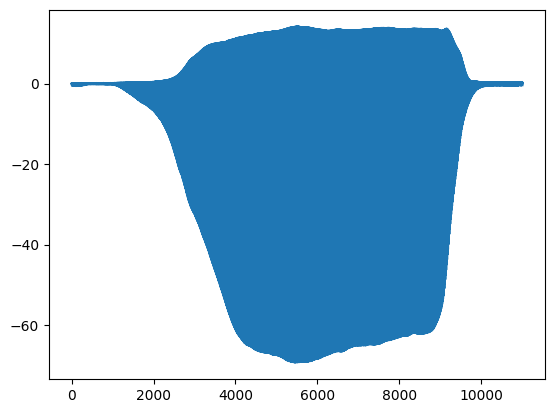

In [72]:
plt.plot(x[0,:])

In [73]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_data = scaler.transform(x_data)
x_og = scaler.transform(x_og)
leaveout_x = scaler.transform(leaveout_x)

(array([3., 0., 0., 3., 0., 0., 6., 0., 0., 3.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

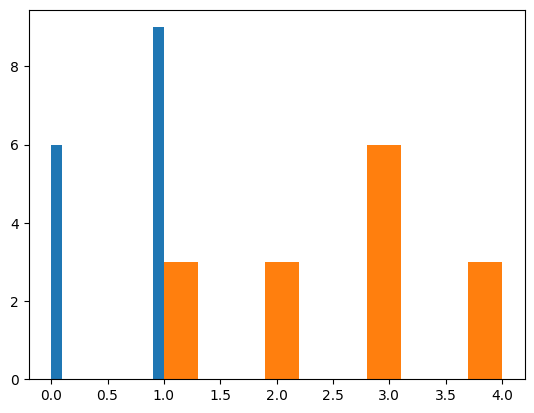

In [ ]:
plt.hist(y[:,0])
plt.hist(y[:,1])

In [52]:
# plot the latent space of the un-augmented data
X_prime, Y_prime = get_data(df)
if by_event:
    X_prime = X_prime.reshape(-1, nframes*11)
else:
    X_prime = X_prime.reshape(-1, nframes*11*3)

X_prime = scaler.transform(X_prime)
X_prime.shape, Y_prime.shape

((15, 11000), (15, 2))

(torch.Size([30, 11000]), torch.Size([30, 2]), torch.Size([123, 11000]))

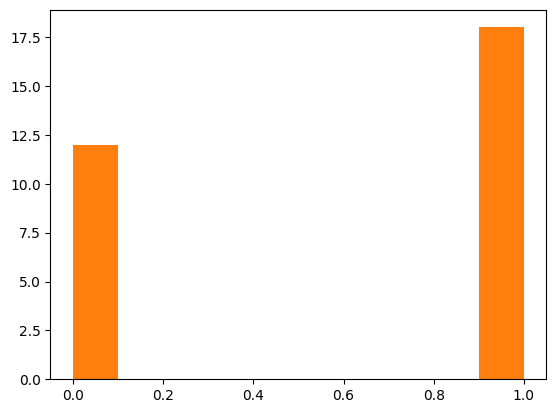

In [53]:
X = to_torch(x)
X_og = to_torch(x_og)
Y = to_torch(y)
plt.hist(Y[:,0])
X_prime = to_torch(X_prime)
Y_prime = to_torch(Y_prime)

X = torch.cat((X, X_prime), dim=0)
Y = torch.cat((Y, Y_prime), dim=0)
plt.hist(Y[:,0])
X_og = torch.cat((X_og, X_prime), dim=0)
X.shape, Y.shape, X_og.shape

(array([6., 0., 0., 0., 0., 0., 0., 0., 0., 9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

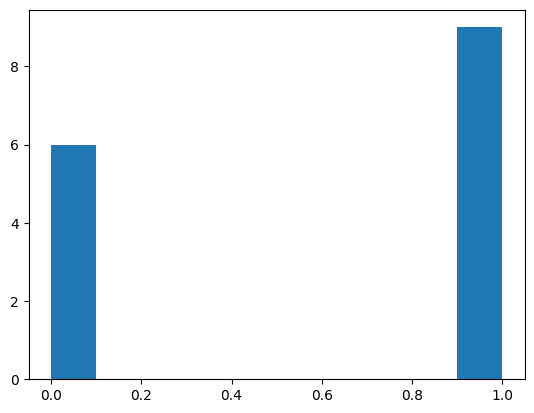

In [54]:
plt.hist(y[:,0])

In [55]:
# train test split
indicies = np.arange(X.shape[0])
np.random.shuffle(indicies)
train_indicies = indicies[:int(0.8*X.shape[0])]
test_indicies = indicies[int(0.8*X.shape[0]):]
X_train = X[train_indicies,:]
X_test = X[test_indicies,:]
Y_train = Y[train_indicies,:]
Y_test = Y[test_indicies,:]
X_og_train = X_og[train_indicies,:]
X_og_test = X_og[test_indicies,:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, X_og_train.shape, X_og_test.shape
# why are my Y's all being turned into 1's!?



(torch.Size([24, 11000]),
 torch.Size([6, 11000]),
 torch.Size([24, 2]),
 torch.Size([6, 2]),
 torch.Size([24, 11000]),
 torch.Size([6, 11000]))

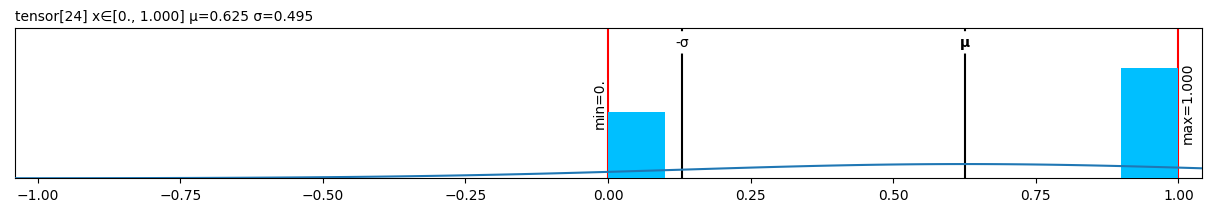

In [56]:
Y_train[:,0].plt

In [59]:
config = {
    'estimator_type': 'VAE',
    'n_inputs': X.shape[1],
    'n_outputs': X.shape[1],
    'input_dim': X.shape[1],
    'is_VAE': True,
    'batch_size':512, 
    'epochs':1001, 
    'verbose':1,
    'latent_dim': 2,
    'lr_init':5e-3,
    'reg_factor':0,
    'n_layers':3,
    'hidden_dim':int(X.shape[1]/100),
    'beta':0,
    'device':'cuda', # makes it run on GPU
}

In [60]:
reg = kmk.Trainer(**config)
reg.estimator


VAE(
  (fc1): Linear(in_features=11000, out_features=110, bias=True)
  (encoder_layers): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
  )
  (out1): Linear(in_features=110, out_features=2, bias=True)
  (out2): Linear(in_features=110, out_features=2, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=11000, out_features=110, bias=True)
    (1): ModuleList(
      (0): Linear(in_features=110, out_features=110, bias=True)
      (1): Linear(in_features=110, out_features=110, bias=True)
      (2): Linear(in_features=110, out_features=110, bias=True)
    )
    (2): Linear(in_features=110, out_features=2, bias=True)
    (3): Linear(in_features=110, out_features=2, bias=True)
  )
  (fc3): Linear(in_features=2, out_features=110, bias=True)
  (decoder_layers): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
 

In [61]:
reg.fit(X_train, X_og_train)

====> Epoch: 0 Average loss: 79218.335937500 Time: 0.18
Loss components: {'VAE_loss': tensor cuda:0 7.922e+04}
====> Epoch: 1 Average loss: 85152.132812500 Time: 0.17
Loss components: {'VAE_loss': tensor cuda:0 8.515e+04}
====> Epoch: 2 Average loss: 73503.914062500 Time: 0.18
Loss components: {'VAE_loss': tensor cuda:0 7.350e+04}
====> Epoch: 3 Average loss: 63942.265625000 Time: 0.18
Loss components: {'VAE_loss': tensor cuda:0 6.394e+04}
====> Epoch: 4 Average loss: 65004.781250000 Time: 0.17
Loss components: {'VAE_loss': tensor cuda:0 6.500e+04}
====> Epoch: 5 Average loss: 41352.335937500 Time: 0.18
Loss components: {'VAE_loss': tensor cuda:0 4.135e+04}
====> Epoch: 6 Average loss: 38021.804687500 Time: 0.17
Loss components: {'VAE_loss': tensor cuda:0 3.802e+04}
====> Epoch: 7 Average loss: 32359.015625000 Time: 0.19
Loss components: {'VAE_loss': tensor cuda:0 3.236e+04}
====> Epoch: 8 Average loss: 27077.169921875 Time: 0.17
Loss components: {'VAE_loss': tensor cuda:0 2.708e+04}
=

KeyboardInterrupt: 

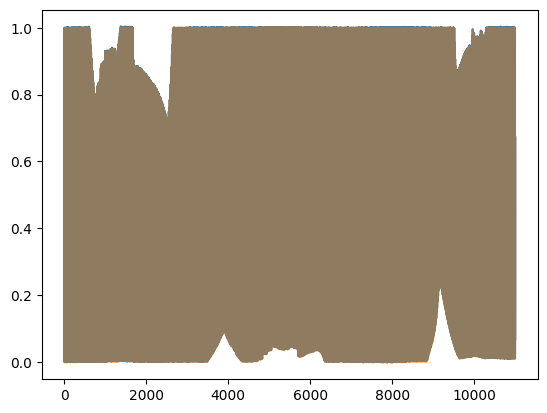

In [62]:
# plot the recon error
X_hat = reg.predict(X.to('cuda'))
plt.plot(X_hat[0].detach().cpu().numpy())
plt.plot(X[0].detach().cpu().numpy(), alpha=0.5)


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 3.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

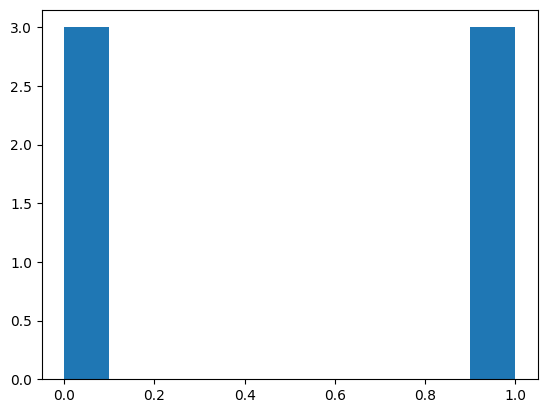

In [63]:
plt.hist(Y_test[:,0])

In [64]:
# plot the losses
import plotly.express as px
px.line(reg.losses.detach().cpu(), title='Losses')

In [75]:
# pass the data through the model
X_prime_hat = reg.predict(X_prime.to('cuda'))
X_prime_hat = X_prime_hat.detach().cpu().numpy()
X_prime_hat.shape, X_prime.shape, Y.shape

((45, 11000), torch.Size([15, 11000]), torch.Size([30, 2]))

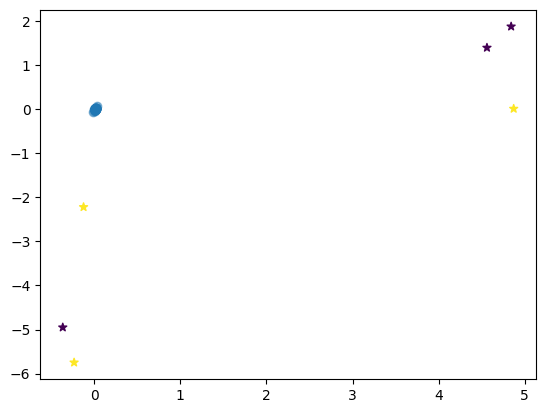

In [76]:
# get the encoded latent space and plot
X_encoded = reg.estimator.encode(X_test.to(reg.device))[0].detach().cpu().numpy()
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=Y_test[:,0], marker='*')
# plot X_prime_hat as red dots
plt.scatter(X_prime_hat[:,0], X_prime_hat[:,1], marker='o', alpha=0.5)

In [78]:
import plotly.express as px
# cmap is red to blue
# encoded_df 
Edf = pd.DataFrame(X_encoded[:, 0:2], columns=['x1', 'x2'])
Edf['Pain_Cohort'] = Y_test[:,0]
Edf['Eaton_Litter'] = Y_test[:,1]
# make the pain cohort categorical
Edf['Pain_Cohort'] = Edf['Pain_Cohort'].astype('category')
# now make the pain 1 category * and 0 category o
#Edf['Pain_Cohort'] = Edf['Pain_Cohort'].apply(lambda x: '*' if x == 1 else 'o')
fig = px.scatter(Edf, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the size of the pain cohort bigger
# fig.update_traces(marker=dict(size=12,
#                                 line=dict(width=2,
#                                             color='DarkSlateGrey')),
#                     selector=dict(mode='markers', symbol='*')) 
# # make the markers bigger with nicer backgrounds
fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
# we want to really emphasize the Pain Cohort == 1 group. lets make the marker size much larger
fig.update_traces(marker=dict(size=209,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers', symbol='o'))
# make the figure larger and have a square aspect ratio
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue",
)
# add the X_prime_hat as red dots
# color the using Y_prime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=X_prime_hat[:,0],
        y=X_prime_hat[:,1],
        mode="markers",
        marker=dict(
            color=Y_prime[:,0],
            size=12,
            line=dict(
                color='Red',
                width=2
            )
        ),
        name="X_prime_hat"
    )
)
# add leaveout_x to the plot
leaveout_encoded = reg.estimator.encode(to_torch(leaveout_x).to(reg.device))[0].detach().cpu().numpy()
fig.add_trace(
    go.Scatter(
        x=leaveout_encoded[:,0],
        y=leaveout_encoded[:,1],
        mode="markers",
        marker=dict(
            color='black',
            size=12,
            line=dict(
                color='black',

                width=2, 
            )
        )
    )
)


fig.show()
# save as latent space.html
fig.write_html("latent_space.html")

In [79]:
reg.estimator
# get the number of learnable parameters
sum(p.numel() for p in reg.estimator.parameters() if p.requires_grad)

2505144

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(X_prime, X_prime_hat)
mse = mean_squared_error(X_prime, X_prime_hat)
mae = mean_absolute_error(X_prime, X_prime_hat)
print(f'r2: {r2}, mse: {mse}, mae: {mae}')


ValueError: Found input variables with inconsistent numbers of samples: [15, 45]

In [ ]:
# plot the predictions of X_prime
pred  = reg.predict(X_prime.to(reg.device))
pred = pred.detach().cpu().numpy()

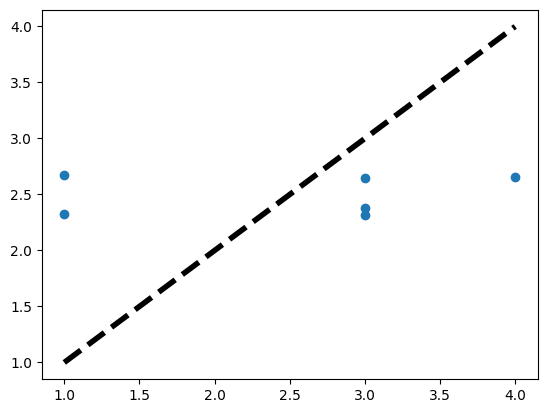

In [81]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_encoded, Y_test[:,1])
lin_reg.score(X_encoded, Y_test[:,1])
# plot the parity
plt.scatter(Y_test[:,1], lin_reg.predict(X_encoded))
# parity line
plt.plot([Y_test[:,1].min(), Y_test[:,1].max()], [Y[:,1].min(), Y_test[:,1].max()], 'k--', lw=4)


ValueError: x and y must be the same size

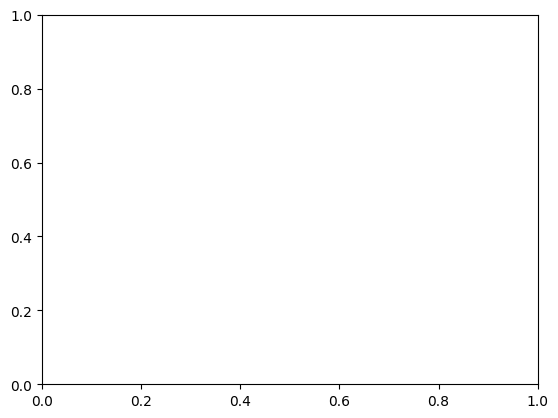

In [82]:
# plot the parity of the predictions
pred = reg.predict(X.to(reg.device)).detach().cpu().numpy()
plt.scatter(X_og[:,0], pred[:,0])